In [1]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs


# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
np.random.seed(0)

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/amiangshu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/amiangshu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using TensorFlow backend.
/home/amiangshu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/amiangshu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/amiangshu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: Fut

In [2]:
from sklearn.model_selection import train_test_split
#load data
data = pd.read_csv('code-review-dataset-full.csv', sep=',', header=0)

#data  =pd.read_excel('../code-review-dataset-full.xlsx')
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

In [3]:
label_names = ["is_toxic"]
y_train = train_data[label_names].values

/opt/anaconda/envs/tfgpu-3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda/envs/tfgpu-3.6.8/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


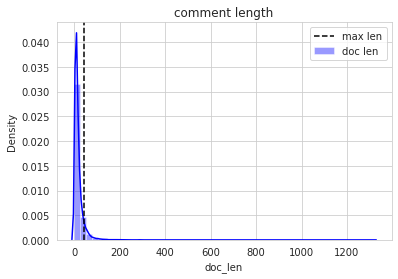

In [4]:

train_data['doc_len'] = train_data['message'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_data['doc_len'].mean() + train_data['doc_len'].std()).astype(int)

sns.distplot(train_data['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [5]:
print(train_data)

                                                 message  is_toxic  doc_len
803    Can you delete the whitespace here? Sorry to n...         0       20
17226  We can get rid of this function with a simple ...         0       13
7513      Have I mentioned that self hrefs are retarded?         0        8
11102  cleanup should only be called if it actually w...         0       18
11527  severity MEDIUM? Yeah they are considered brea...         1       14
...                                                  ...       ...      ...
11284  This is generated by tools/conf/generate_sampl...         0       16
11964  This docstring needs to be moved under the cla...         0       12
5390   This will be eventually removed by the migrati...         0       18
860    Close. I don't think ProjectSpec is the right ...         0       82
15795  allow_put should be False. (as well as segment...         0       10

[15656 rows x 3 columns]


In [6]:
from sklearn.utils import shuffle 

raw_docs_train = train_data['message'].tolist()
raw_docs_test = test_data['message'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

  4%|▍         | 641/15656 [00:00<00:02, 6406.13it/s]

pre-processing train data...


100%|██████████| 3915/3915 [00:00<00:00, 6656.14it/s]


tokenizing input data...
dictionary size:  16808


In [7]:
print(word_seq_train)

[[   0    0    0 ... 1354 1409  337]
 [   0    0    0 ... 6776  567 2766]
 [   0    0    0 ...   10 6777 2216]
 ...
 [   0    0    0 ...  775   50   21]
 [  47    3 1814 ...  213 1257   31]
 [   0    0    0 ...   14  705  395]]


In [8]:
#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4
nb_words=30000

In [9]:
keras.backend.clear_session()

In [10]:
from keras.layers import BatchNormalization
import tensorflow as tf

without_mod = tf.keras.Sequential()

without_mod.add(Embedding(nb_words,embed_dim,input_length=max_seq_len,trainable=False))
without_mod.add(Bidirectional(LSTM(32)))
without_mod.add(Dense(32,activation='relu'))
without_mod.add(Dropout(0.4))
without_mod.add(Dense(1,activation='sigmoid'))
without_mod.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 43, 300)           9000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                85248     
____________________________________________________________

In [11]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

without_mod.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history_withoutembed = without_mod.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Train on 10959 samples, validate on 4697 samples
Epoch 1/40
10959/10959 [==============================] - 4s 358us/sample - loss: 0.5531 - acc: 0.7917 - val_loss: 0.4864 - val_acc: 0.8120
Epoch 2/40
10959/10959 [==============================] - 3s 282us/sample - loss: 0.4962 - acc: 0.8077 - val_loss: 0.4792 - val_acc: 0.8120
Epoch 3/40
10959/10959 [==============================] - 3s 280us/sample - loss: 0.4849 - acc: 0.8077 - val_loss: 0.4689 - val_acc: 0.8120
Epoch 4/40
10959/10959 [==============================] - 3s 299us/sample - loss: 0.4662 - acc: 0.8078 - val_loss: 0.4568 - val_acc: 0.8120
Epoch 5/40
10959/10959 [==============================] - 3s 282us/sample - loss: 0.4366 - acc: 0.8107 - val_loss: 0.4227 - val_acc: 0.8118
Epoch 6/40
10959/10959 [==============================] - 3s 283us/sample - loss: 0.4095 - acc: 0.8198 - val_loss: 0.3972 - val_acc: 0.8269
Epoch 7/40
10959/10959 [==============================] - 3s 289us/sample - loss: 0.3885 - acc: 0.8328 - val_lo

In [13]:
predictions = without_mod.predict_classes(word_seq_test)
#sample=pd.read_csv('SEtest_dat.csv')
#sample['predictions']= (predictions>0.5).astype(int)

In [15]:
y_test = test_data[label_names].values
print(y_test)

[[0]
 [0]
 [0]
 ...
 [1]
 [0]
 [0]]


In [18]:
import sklearn
print("Accuracy Without GloVe :")
print(sklearn.metrics.accuracy_score(y_test, predictions))

from sklearn import metrics
print(metrics.classification_report(y_test, predictions))

Accuracy Without GloVe :
0.8883780332056194
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      3153
           1       0.81      0.55      0.66       762

    accuracy                           0.89      3915
   macro avg       0.86      0.76      0.80      3915
weighted avg       0.88      0.89      0.88      3915



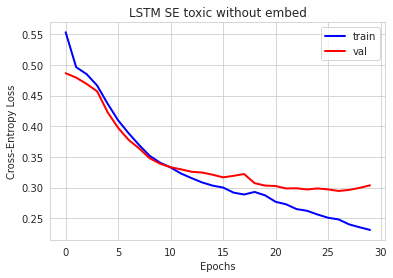

In [19]:
#generate plots
plt.figure()
plt.plot(history_withoutembed.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history_withoutembed.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM SE toxic without embed')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

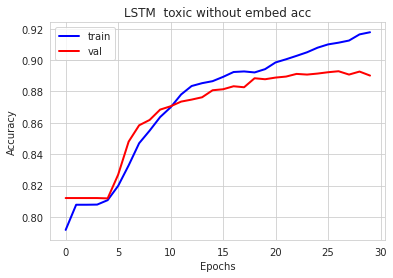

In [20]:
plt.figure()
plt.plot(history_withoutembed.history['acc'], lw=2.0, color='b', label='train')
plt.plot(history_withoutembed.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('LSTM  toxic without embed acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [21]:
keras.backend.clear_session()

In [23]:
#Embedding Started

In [25]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('../crawl-300d-2M.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

1282it [00:00, 12816.38it/s]

loading word embeddings...


2000005it [01:51, 17990.66it/s]

found 1999997 word vectors


In [26]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 5258


In [27]:
print("sample words not found: ", np.random.choice(words_not_found, 10))


sample words not found:  ['listenforchangestobuildfiles' '43ec' 'pmanager' 'denorm' 'appendrestore'
 'magicmock' 'netloc' 'endtracking' "rmw'ing" 'cliprrect']


In [28]:
from keras.layers import BatchNormalization
import tensorflow as tf

model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 43, 300)           5042700   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                85248     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,130,061
Trainable params: 87,361
Non-trainable params: 5,042,700
_________________________________________________________________


In [29]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Train on 10959 samples, validate on 4697 samples
Epoch 1/40
10959/10959 [==============================] - 4s 392us/sample - loss: 0.5487 - acc: 0.7723 - val_loss: 0.4347 - val_acc: 0.8126
Epoch 2/40
10959/10959 [==============================] - 3s 289us/sample - loss: 0.3521 - acc: 0.8425 - val_loss: 0.2720 - val_acc: 0.8795
Epoch 3/40
10959/10959 [==============================] - 3s 284us/sample - loss: 0.2542 - acc: 0.8970 - val_loss: 0.2282 - val_acc: 0.9108
Epoch 4/40
10959/10959 [==============================] - 3s 286us/sample - loss: 0.2092 - acc: 0.9231 - val_loss: 0.2128 - val_acc: 0.9221
Epoch 5/40
10959/10959 [==============================] - 3s 297us/sample - loss: 0.1830 - acc: 0.9359 - val_loss: 0.2081 - val_acc: 0.9242
Epoch 6/40
10959/10959 [==============================] - 3s 286us/sample - loss: 0.1686 - acc: 0.9398 - val_loss: 0.1987 - val_acc: 0.9274
Epoch 7/40
10959/10959 [==============================] - 3s 288us/sample - loss: 0.1557 - acc: 0.9434 - val_lo

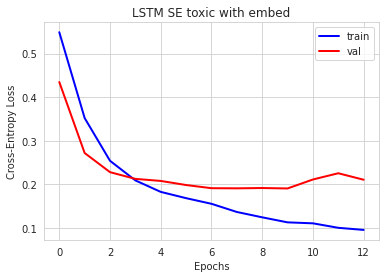

In [30]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM SE toxic with embed')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

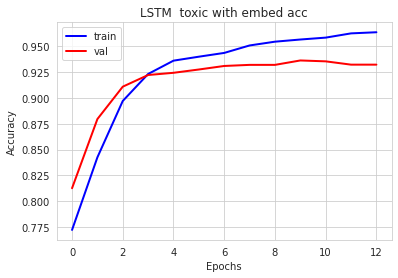

In [31]:
plt.figure()
plt.plot(history.history['acc'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('LSTM  toxic with embed acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [32]:
predictions_withembed = model.predict_classes(word_seq_test)

y_test_withembed = test_data[label_names].values
print(y_test_withembed)

[[0]
 [0]
 [0]
 ...
 [1]
 [0]
 [0]]


In [34]:
import sklearn
print("Accuracy With fastext :")
print(sklearn.metrics.accuracy_score(y_test, predictions_withembed))

from sklearn import metrics
print(metrics.classification_report(y_test, predictions_withembed))

Accuracy With fastext :
0.930779054916986
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3153
           1       0.89      0.73      0.80       762

    accuracy                           0.93      3915
   macro avg       0.91      0.86      0.88      3915
weighted avg       0.93      0.93      0.93      3915



In [35]:
keras.backend.clear_session()

In [36]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('../glove.840B.300d.txt', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))


1107it [00:00, 11065.05it/s]

loading word embeddings...


2196018it [02:23, 15348.75it/s]

found 2196016 word vectors


In [37]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 5317


In [38]:
from keras.layers import BatchNormalization
import tensorflow as tf

model_glove = tf.keras.Sequential()

model_glove.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model_glove.add(Bidirectional(LSTM(32)))
model_glove.add(Dense(32,activation='relu'))
model_glove.add(Dropout(0.4))
model_glove.add(Dense(1,activation='sigmoid'))
model_glove.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 43, 300)           5042700   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                85248     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,130,061
Trainable params: 87,361
Non-trainable params: 5,042,700
_________________________________________________________________


In [39]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history_glove = model_glove.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Train on 10959 samples, validate on 4697 samples
Epoch 1/40
10959/10959 [==============================] - 5s 428us/sample - loss: 0.4980 - acc: 0.7958 - val_loss: 0.4112 - val_acc: 0.8203
Epoch 2/40
10959/10959 [==============================] - 3s 280us/sample - loss: 0.3601 - acc: 0.8345 - val_loss: 0.2946 - val_acc: 0.8620
Epoch 3/40
10959/10959 [==============================] - 3s 279us/sample - loss: 0.2676 - acc: 0.8806 - val_loss: 0.2358 - val_acc: 0.9012
Epoch 4/40
10959/10959 [==============================] - 3s 295us/sample - loss: 0.2141 - acc: 0.9110 - val_loss: 0.2096 - val_acc: 0.9146
Epoch 5/40
10959/10959 [==============================] - 3s 296us/sample - loss: 0.1814 - acc: 0.9286 - val_loss: 0.2020 - val_acc: 0.9231
Epoch 6/40
10959/10959 [==============================] - 3s 291us/sample - loss: 0.1651 - acc: 0.9389 - val_loss: 0.1977 - val_acc: 0.9278
Epoch 7/40
10959/10959 [==============================] - 3s 293us/sample - loss: 0.1470 - acc: 0.9435 - val_lo

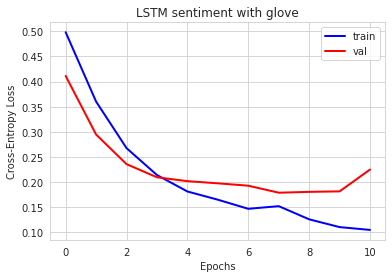

In [41]:
#generate plots
plt.figure()
plt.plot(history_glove.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history_glove.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment with glove')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

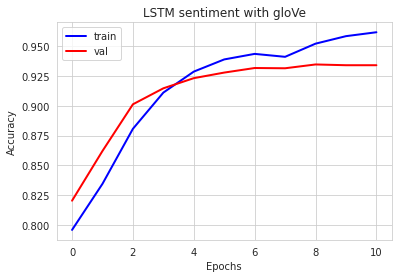

In [42]:
plt.figure()
plt.plot(history_glove.history['acc'], lw=2.0, color='b', label='train')
plt.plot(history_glove.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment with gloVe')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [44]:
predictions_withembed_GloVe = model_glove.predict_classes(word_seq_test)

y_test  = test_data[label_names].values
#print(y_test_withembed)

In [45]:
import sklearn
print("Accuracy With fastext :")
print(sklearn.metrics.accuracy_score(y_test, predictions_withembed_GloVe))

from sklearn import metrics
print(metrics.classification_report(y_test, predictions_withembed_GloVe))

Accuracy With fastext :
0.9323116219667944
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3153
           1       0.91      0.72      0.81       762

    accuracy                           0.93      3915
   macro avg       0.92      0.85      0.88      3915
weighted avg       0.93      0.93      0.93      3915

